In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Paths
spalling_path = '/content/drive/MyDrive/Spalling Data/1200/train'
plain_path = '/content/drive/MyDrive/plain concrete images/resized'

In [7]:
# Load CSVs
spalling_df = pd.read_csv(os.path.join(spalling_path, '_annotations.csv'))
plain_df = pd.read_csv(os.path.join(plain_path, 'labels.csv'))

In [8]:
# Combine labels: 'exposed_rebar' and 'spalling' -> 'spalling'
def map_labels(row):
    if row['class'] in ['exposed_rebar', 'spalling']:
        return 'spalling'
    return 'no_defect'

spalling_df['label'] = spalling_df.apply(map_labels, axis=1)
plain_df['label'] = plain_df['label'].map(lambda x: 'no_defect' if x == 'no_defect' else 'spalling')

In [9]:
# Standardize columns
spalling_df.rename(columns={'filename': 'image_name'}, inplace=True)

# Combine datasets
combined_df = pd.concat([spalling_df[['image_name', 'label']], plain_df[['image_name', 'label']]])

In [10]:
# Add image paths
spalling_df['image_path'] = spalling_df['image_name'].apply(lambda x: os.path.join(spalling_path, x))
plain_df['image_path'] = plain_df['image_name'].apply(lambda x: os.path.join(plain_path, x))
combined_df = pd.concat([spalling_df[['image_path', 'label']], plain_df[['image_path', 'label']]])


In [11]:
# Split dataset
train_df, val_df = train_test_split(combined_df, test_size=0.2, stratify=combined_df['label'], random_state=42)

In [12]:
# Image generator with resizing and augmentation
def create_generators(train_df, val_df):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    return train_generator, val_generator

train_generator, val_generator = create_generators(train_df, val_df)


Found 4260 validated image filenames belonging to 2 classes.
Found 1065 validated image filenames belonging to 2 classes.


In [ ]:
# CNN Model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Callbacks to reduce overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 582ms/step - accuracy: 0.9173 - loss: 0.2282 - val_accuracy: 0.9925 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 77s 578ms/step - accuracy: 0.9735 - loss: 0.0805 - val_accuracy: 0.9897 - val_loss: 0.0426 - learning_rate: 0.0010
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 82s 612ms/step - accuracy: 0.9834 - loss: 0.0624 - val_accuracy: 0.9925 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 583ms/step - accuracy: 0.9874 - loss: 0.0420 - val_accuracy: 0.9991 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 82s 608ms/step - accuracy: 0.9871 - loss: 0.0446 - val_accuracy: 0.9878 - val_loss: 0.0307 - learning_rate: 0.0010


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Saved models/best_model_01_spalling.keras')

In [ ]:
model.save('/content/drive/MyDrive/Saved models/best_model_01_spalling.h5')

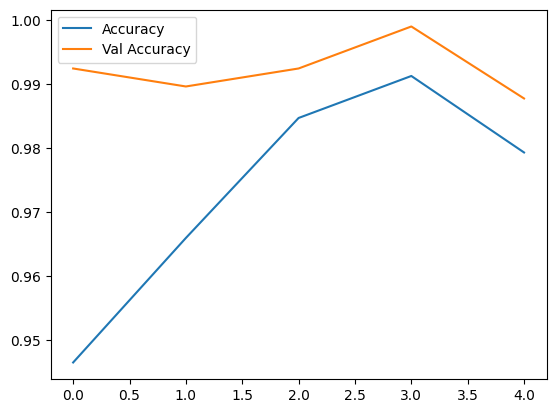

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from PIL import Image

# Evaluate model and calculate metrics
y_true = val_generator.classes
y_pred = (model.predict(val_generator) > 0.5).astype('int32').flatten()

print(classification_report(y_true, y_pred, target_names=['no_defect','spalling']))

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step
              precision    recall  f1-score   support

   no_defect       0.06      0.06      0.06       100
    spalling       0.90      0.90      0.90       965

    accuracy                           0.82      1065
   macro avg       0.48      0.48      0.48      1065
weighted avg       0.82      0.82      0.82      1065



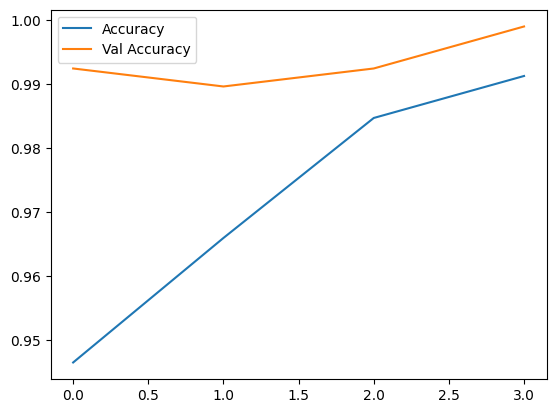

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'][:4], label='Accuracy')
plt.plot(history.history['val_accuracy'][:4], label='Val Accuracy')
plt.legend()
plt.show()

In [ ]:
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize

    prediction = model.predict(img_array)[0][0]
    label = "spalling" if prediction > 0.5 else "no_defect"

    return label,prediction

In [ ]:
# Path to your folder containing 14 images
test_images_folder = "/content/drive/MyDrive/Spalling Data/small test/test folder"

# List all image files
image_files = [os.path.join(test_images_folder, img) for img in os.listdir(test_images_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Run predictions
for img_path in image_files:
    label, confidence = predict_image(img_path, model)
    print(f"Image: {os.path.basename(img_path)} | Predicted: {label} | Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: images (32).jpeg | Predicted: spalling | Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: images (34).jpeg | Predicted: no_defect | Confidence: 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: images (33).jpeg | Predicted: no_defect | Confidence: 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: images.jpeg | Predicted: spalling | Confidence: 0.70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: images (31).jpeg | Predicted: no_defect | Confidence: 0.40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: concrete_crack_jpeg.rf.8af34e8e81caee1fa3d6c6e0f1997683.jpg | Predicted: spalling | Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image: bigstock-183374740_jpg.rf.42381c9a5eab6d89579f40ab5cf8db74.jpg | Predicted: spalling | Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: images (30).jpeg | Predicted: spalling | Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image: concrete-crack-ice_jpg.rf.a06a2757445225f6c37f

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to predict and visualize images
def predict_and_visualize(img_path, model):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize

    # Make prediction
    prediction = model.predict(img_array)[0][0]
    label = "spalling" if prediction > 0.5 else "no_defect"

    # Display image with label
    plt.imshow(mpimg.imread(img_path))
    plt.title(f"Prediction: {label} ({prediction:.2f})")
    plt.axis("off")
    plt.show()

# Path to your folder containing 14 images
test_images_folder = "/content/drive/MyDrive/Spalling Data/small test/test folder"

# List and visualize all images
image_files = [os.path.join(test_images_folder, img) for img in os.listdir(test_images_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]

for img_path in image_files:
    predict_and_visualize(img_path, model)


Output hidden; open in https://colab.research.google.com to view.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import tensorflow as tf

# Define the path to your model
model_path = "/content/drive/My Drive/Saved models/best_model_01_spalling.keras"

# Load the model
model = tf.keras.models.load_model(model_path)

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,734,789 (254.57 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,489,860 (169.72 MB)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 38/134 ━━━━━━━━━━━━━━━━━━━━ 23:23 15s/step - accuracy: 0.9993 - loss: 0.0147

KeyboardInterrupt: 